Notebook for demonstrating the QRE pipeline.

In [1]:
import itertools

import numpy as np
from qualtran import QUInt
from qualtran.bloqs.mod_arithmetic import CModMulK
from qualtran.surface_code import (
    AlgorithmSummary,
    CompactDataBlock,
    FastDataBlock,
    PhysicalCostModel,
    PhysicalParameters,
    QECScheme,
    SimpleDataBlock,
)


**Step 1**: Define key size

In [2]:
key_size = 2048

**Step 2.** Create the Bloq which defines the subcircuit dominating the resource cost of the algorithm. In this case (and most cases) it is the controlled modular multiplier.

- `modulus` is the integer to be factored. Since the resource cost is (usually) the same for any $n$-bit integer, for simplicity we take it to be $N = 2^n - 1$.
- `multiplicand` is the classically pre-computed constant which is multiplied by the value in the quantum register, i.e., the number $a$ in the quantum computation $\ket{x} \mapsto \ket{ax \mod N}$.<br>The resource cost of the controlled modular multiplier is also (usually) invariant in the value of $a$. Since $a$ must be coprime to $N$, for simplicity we take it to be $a = N - 1 = 2^n - 2$.

In [3]:
modulus = 2**key_size - 1
multiplicand = 2**key_size - 2

mod_mul = CModMulK(dtype=QUInt(key_size), k=multiplicand, mod=modulus)

**Step 3.** Create logical resource estimates for the subcircuit.

*Note: this steps takes a while! (About 1 min)*

In [4]:
alg_controlled_mod_mul = AlgorithmSummary.from_bloq(mod_mul)
alg_controlled_mod_mul

AlgorithmSummary(n_algo_qubits=6143, n_logical_gates=GateCounts(t=0, toffoli=0, cswap=2048, and_bloq=41922560, clifford=335339520, rotation=0, measurement=41922560), n_rotation_layers=None)

**Step 4.** Compute the number of times the subcircuit is repeated in the entire algorithm. To again match the implementation of [Gidney and Ekerå](https://doi.org/10.22331/q-2021-04-15-433), we take this to be $1.5 n$.

In [5]:
subcircuit_reps = int(1.5 * key_size)

**Step 5**: Retrieve logical estimates for the entire circuit (modular exponentiator) by multiplying the logical resources estimates for the subcircuit (controlled modular multiplier) by the number of repetitions

In [6]:
alg_mod_exp = AlgorithmSummary(
    n_algo_qubits=alg_controlled_mod_mul.n_algo_qubits,
    n_logical_gates=alg_controlled_mod_mul.n_logical_gates * subcircuit_reps,
)
alg_mod_exp

AlgorithmSummary(n_algo_qubits=6143, n_logical_gates=GateCounts(t=0, toffoli=0, cswap=6291456, and_bloq=128786104320, clifford=1030163005440, rotation=0, measurement=128786104320), n_rotation_layers=None)

### **Physical resource estimation**

### **OPTION 1**: Physical resource estimates w/ Qualtran

**Step 6a**: Create cost model. In qualtran we currently have a choice between the gidney-fowler model, and the beverland et al model. These can be further customized as per requirements.

In [7]:
# For minimal configuration, you can use a set of defaults from
# the literature. Here: Gidney and Fowler (2018).

cost_model = PhysicalCostModel.make_gidney_fowler(data_d=33)
cost_model

PhysicalCostModel(physical_params=PhysicalParameters(physical_error=0.001, cycle_time_us=1.0), data_block=SimpleDataBlock(data_d=33, routing_overhead=0.5), factory=CCZ2TFactory(distillation_l1_d=15, distillation_l2_d=31), qec_scheme=QECScheme(error_rate_scaler=0.1, error_rate_threshold=0.01))

**Step 6b:** Test resource estimation for a single controlled modular multiplier using a *distance* 25 code with the gidney fowler model.

In [8]:
print(
    f"Duration {cost_model.duration_hr(alg_controlled_mod_mul):.2f} hr",
    f"\nPhysical Qubits {cost_model.n_phys_qubits(alg_controlled_mod_mul):,d}",
    f"\nError {cost_model.error(alg_controlled_mod_mul):.2g}",
)

Duration 1.99 hr 
Physical Qubits 20,218,174 
Error 0.0023


**Step 6c**: Resource estimate for the modular exponentiator in the gidney fowler model

In [9]:
print(
    f"Duration {cost_model.duration_hr(alg_mod_exp):.2f} hr",
    f"\nPhysical Qubits {cost_model.n_phys_qubits(alg_mod_exp):,d}",
    f"\nError {cost_model.error(alg_mod_exp):.2g}",
)

Duration 6099.75 hr 
Physical Qubits 20,218,174 
Error 7.1


*Note:* As we can see from above, the error is really bad. We potentially need a larger distance code or a differernt distillation method. We haven't fully incorporated all of Gidney's techniques yet, so , this cost is bound to go down.

**Step 7**: Function testing many possible combinations of cost models to compute physical resource estimates. We vary the 

- datablock type (i.e. the layout of logical qubits on the surface code), 
- the factory type (CCZ vs T), 
- the QEC scheme (this takes into account some assumptions abotu the logical noise scaling etc.), and finally 
- some more concrete params about the physical error rate etc.

In [10]:
from qualtran.surface_code import CCZ2TFactory, FifteenToOne

data_d = 27

data_blocks = [
    SimpleDataBlock(data_d=data_d),
    CompactDataBlock(data_d=data_d),
    FastDataBlock(data_d=data_d),
]

factories = [
    CCZ2TFactory(),
    FifteenToOne(data_d, data_d, data_d),
]

schemes = [
    QECScheme.make_gidney_fowler(),
    QECScheme.make_beverland_et_al(),
]

phys_params = [
    PhysicalParameters.make_beverland_et_al(),
    PhysicalParameters.make_beverland_et_al(optimistic_err_rate=True),
    PhysicalParameters.make_gidney_fowler(),
    PhysicalParameters.make_gidney_fowler(optimistic_err_rate=True),
]

In [ ]:
def compute_physical_estimates(alg, data_block, factory, scheme, phys):  # noqa: ANN201, ANN001
    """Estimate the runtime and physical qubits required for the algorithm."""  # noqa: DOC201
    model = PhysicalCostModel(
        data_block=data_block, factory=factory, qec_scheme=scheme, physical_params=phys
    )
    duration_hr_estimate = model.duration_hr(alg)
    n_physical_qubits_estimate = model.n_phys_qubits(alg)

    return {
        "duration_hr_estimate": duration_hr_estimate,
        "n_physical_qubits_estimate": n_physical_qubits_estimate,
    }

In [12]:
duration_hr_estimates = []
n_physical_qubits_estimates = []
for data_block, factory, scheme, phys in itertools.product(
    data_blocks, factories, schemes, phys_params
):
    costs = compute_physical_estimates(
        alg=alg_mod_exp, data_block=data_block, factory=factory, scheme=scheme, phys=phys
    )

    duration_hr_estimates.append(costs["duration_hr_estimate"])
    n_physical_qubits_estimates.append(costs["n_physical_qubits_estimate"])

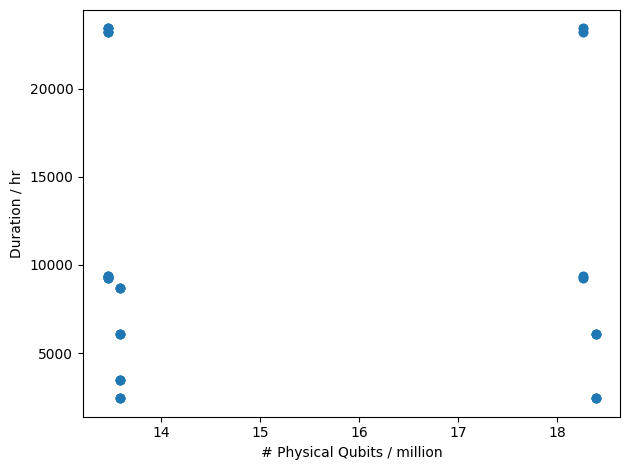

In [13]:
from matplotlib import pyplot as plt

plt.scatter(np.array(n_physical_qubits_estimates) / 1e6, duration_hr_estimates)
plt.xlabel("# Physical Qubits / million")
plt.ylabel("Duration / hr")
plt.tight_layout()

#### **Option 2**: Using a combination of Qualtran and Microsoft QRE

We can alternatively retrieve logical resource estimates from Qualtran and use Azure's resource estimator to create the physical resource estimates.

In [14]:
t_and_ccz_count = alg_mod_exp.n_logical_gates.total_t_and_ccz_count()
t_and_ccz_count

{'n_t': 0, 'n_ccz': 128792395776}

In [15]:
from qsharp.estimator import LogicalCounts

logical_counts = LogicalCounts(
    {
        "numQubits": alg_mod_exp.n_algo_qubits,
        "tCount": t_and_ccz_count['n_t'],
        "cczCount": t_and_ccz_count['n_ccz'],
    }
)
logical_counts

{'numQubits': 6143,
 'tCount': 0,
 'rotationCount': 0,
 'rotationDepth': 0,
 'cczCount': 128792395776,
 'ccixCount': 0,
 'measurementCount': 0}

In [16]:
logical_counts.estimate()

Runtime,63 days,"Total runtime This is a runtime estimate for the execution time of the algorithm. In general, the execution time corresponds to the duration of one logical cycle (14,000 nanosecs) multiplied by the 386,377,187,328 logical cycles to run the algorithm. If however the duration of a single T factory (here: 174,400 nanosecs) is larger than the algorithm runtime, we extend the number of logical cycles artificially in order to exceed the runtime of a single T factory."
rQOPS,893.50M,"Reliable quantum operations per second The value is computed as the number of logical qubits after layout (12,509) (with a logical error rate of 1.03e-19) multiplied by the clock frequency (71,428.57), which is the number of logical cycles per second."
Physical qubits,31.58M,"Number of physical qubits This value represents the total number of physical qubits, which is the sum of 30,647,050 physical qubits to implement the algorithm logic, and 936,360 physical qubits to execute the T factories that are responsible to produce the T states that are consumed by the algorithm."
Logical algorithmic qubits,12.51k,"Number of logical qubits for the algorithm after layout Laying out the logical qubits in the presence of nearest-neighbor constraints requires additional logical qubits. In particular, to layout the $Q_{\rm alg} = 6,143$ logical qubits in the input algorithm, we require in total $2 \cdot Q_{\rm alg} + \lceil \sqrt{8 \cdot Q_{\rm alg}}\rceil + 1 = 12,509$ logical qubits."
Algorithmic depth,386.38G,"Number of logical cycles for the algorithm To execute the algorithm using _Parallel Synthesis Sequential Pauli Computation_ (PSSPC), operations are scheduled in terms of multi-qubit Pauli measurements, for which assume an execution time of one logical cycle. Based on the input algorithm, we require one multi-qubit measurement for the 0 single-qubit measurements, the 0 arbitrary single-qubit rotations, and the 0 T gates, three multi-qubit measurements for each of the 128,792,395,776 CCZ and 0 CCiX gates in the input program, as well as No rotations in algorithm multi-qubit measurements for each of the 0 non-Clifford layers in which there is at least one single-qubit rotation with an arbitrary angle rotation."
Logical depth,386.38G,"Number of logical cycles performed This number is usually equal to the logical depth of the algorithm, which is 386,377,187,328. However, in the case in which a single T factory is slower than the execution time of the algorithm, we adjust the logical cycle depth to exceed the T factory's execution time."
Clock frequency,71.43k,Number of logical cycles per second This is the number of logical cycles that can be performed within one second. The logical cycle time is 14 microsecs.
Number of T states,515.17G,"Number of T states consumed by the algorithm To execute the algorithm, we require one T state for each of the 0 T gates, four T states for each of the 128,792,395,776 CCZ and 0 CCiX gates, as well as No rotations in algorithm for each of the 0 single-qubit rotation gates with arbitrary angle rotation."
Number of T factories,17,"Number of T factories capable of producing the demanded 515,169,583,104 T states during the algorithm's runtime The total number of T factories 17 that are executed in parallel is computed as $\left\lceil\dfrac{\text{T states}\cdot\text{T factory duration}}{\text{T states per T factory}\cdot\text{algorithm runtime}}\right\rceil = \left\lceil\dfrac{515,169,583,104 \cdot 174,400\;\text{ns}}{1 \cdot 5,409,280,622,592,000\;\text{ns}}\right\rceil$"
Number of T factory invocations,30.30G,"Number of times all T factories are invoked In order to prepare the 515,169,583,104 T states, the 17 copies of the T factory are repeatedly invoked 30,304,093,124 times."
Physical algorithmic qubits,30.65M,"Number of physical qubits for the algorithm after layout The 30,647,050 are the product of the 12,509 logical qubits after layout and the 2,450 physical qubits that encode a single logical qubit."
